In [6]:
# required imports
import csv
from tkinter import messagebox
import psycopg2
import tkinter as tk
from tkinter import ttk, messagebox, Menu, filedialog
from tkinter import Menu, filedialog
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import re

In [7]:
class DatabaseCreator:
    '''
    - This assumes psycopg2 module is installed
    - PostgreSQL version 15.4 must be installed too
    - PostgreSQL from: https://sbp.enterprisedb.com/getfile.jsp?fileid=1258649
    '''
    def __init__(self, host, port, user, password):
        self.host = host
        self.port = port
        self.user = user
        self.password = password

    def database_exists(self, database_name):
        try:
            connection = psycopg2.connect(
                host=self.host,
                port=self.port,
                user=self.user,
                password=self.password
            )
            cursor = connection.cursor()
            cursor.execute(
                "SELECT 1 FROM pg_database WHERE datname = %s", (database_name,)
            )
            return cursor.fetchone() is not None
        except psycopg2.OperationalError:
            return False
        finally:
            if cursor:
                cursor.close()
            if connection:
                connection.close()

    def create_database(self, database_name):
        try:
            connection = psycopg2.connect(
                host=self.host,
                port=self.port,
                user=self.user,
                password=self.password
            )
            connection.autocommit = True
            cursor = connection.cursor()

            if self.database_exists(database_name):
                print(f"Database '{database_name}' already exists.")
            else:
                cursor.execute(
                    f'CREATE DATABASE {database_name} TEMPLATE template1')
                print(f"Database '{database_name}' created successfully!")

        except Exception as e:
            print(f"Error creating database: {e}\nMake sure you have installed PostgreSQL\nand start the PostgreSQL server")
        finally:
            if cursor:
                cursor.close()
            if connection:
                connection.close()

In [8]:
class DatabaseManager:
    #This class handles ll database connections
    
    def __init__(self, host, port, dbname, user, password):
        self.host = host
        self.port = port
        self.dbname = dbname
        self.user = user
        self.password = password
        self.connection = None
        self.cursor = None

    def connect(self):
        try:
            # Open a database connection
            self.connection = psycopg2.connect(
                host=self.host,
                port=self.port,
                dbname=self.dbname,
                user=self.user,
                password=self.password,
            )
            # Create a cursor for database operations
            self.cursor = self.connection.cursor()
            print("Connected to the postgreSQL DB successfully")
        except psycopg2.OperationalError:
            messagebox.showerror(
                "Database Connection Error",
                "Failed to connect to the database."
            )
    def close(self):
        try:
            # Close the cursor
            if self.cursor:
                self.cursor.close()
            if self.connection:
                self.connection.commit()
        except Exception as e:
            messagebox.showerror(
                "Error", f"An error occurred while closing the database connection: {e}")
            raise
        finally:
            if self.connection:
                self.connection.close()

In [9]:
class DataLoader:
    '''
    1. Allows the user to select csv files
    2. Performs data cleaning
    3. Loads the cleaned data into the database entities
    '''

    def __init__(self, db_manager):
        self.db_manager = db_manager

    def create_table_tx_params(self):
        self.db_manager.cursor.execute(
            """CREATE TABLE IF NOT EXISTS tx_params_dab_new (
                                id SERIAL PRIMARY KEY,
                                date DATE,
                                eid TEXT,
                                site TEXT,
                                freq TEXT,
                                block TEXT,
                                servlabel1 TEXT,
                                servlabel2 TEXT,
                                servlabel3 TEXT,
                                servlabel4 TEXT,
                                servlabel10 TEXT
                                )"""
        )

    def create_table_tx_antenna(self):
        self.db_manager.cursor.execute(
            """CREATE TABLE IF NOT EXISTS tx_antenna_dab_new (
                                id SERIAL PRIMARY KEY,
                                ngr TEXT,
                                siteheight TEXT,
                                inuseaeht TEXT,
                                inuseerptotal TEXT
                            )"""
        )

    def insert_data(self, table_name, column_names, data, subset_size=None):
        """This function inserts data into the correct table and provides user feedback"""
        # Filter the data using subset_size
        if subset_size is not None:
            data = data.head(subset_size)

        # Convert data to a dictionary
        data_list = data.to_dict("records")

        # Prepare the INSERT query dynamically
        insert_query = f"""INSERT INTO {table_name} ({', '.join(column_names)})
                  VALUES ({', '.join(['%(' + col + ')s' for col in column_names])})
                  ON CONFLICT DO NOTHING"""
        # Execute query statement to insert each row of data
        num_rows_written = 0
        for row_data in data_list:
            self.db_manager.cursor.execute(insert_query, row_data)
            if self.db_manager.cursor.rowcount > 0:
                num_rows_written += 1
        # Commit changes
        self.db_manager.connection.commit()

        # User feedback
        total_rows = len(data_list)
        duplicates = total_rows - num_rows_written
        message = f"{num_rows_written} records were written and {duplicates} duplicates were avoided."
        messagebox.showwarning("Data Insertion Feedback:", message)

    def load_data(self, file_path, subset_size=None):
        # Connect to the database
        self.db_manager.connect()
        # Create tables in the database and insert data
        if "TxParamsDAB" in file_path:
            self.create_table_tx_params()
            data = pd.read_csv(file_path, delimiter=",", encoding="latin-1")
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                data = self.clean_tx_params_data(data)
            self.insert_data(
                "tx_params_dab_new",
                [
                    "id",
                    "date",
                    "eid",
                    "site",
                    "freq",
                    "block",
                    "servlabel1",
                    "servlabel2",
                    "servlabel3",
                    "servlabel4",
                    "servlabel10",
                ],
                data,
                subset_size,
            )
        elif "TxAntennaDAB" in file_path:
            self.create_table_tx_antenna()
            data = pd.read_csv(file_path, delimiter=",", encoding="latin-1")
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                data = self.clean_tx_antenna_data(data)
            self.insert_data(
                "tx_antenna_dab_new",
                ["id", "ngr", "siteheight", "inuseaeht", "inuseerptotal"],
                data,
                subset_size,
            )
        # Commit the changes and close the database
        self.db_manager.connection.commit()
        self.db_manager.close()
        print("Data loaded into the database")

    def clean_tx_params_data(self, data):
        # Perform data cleaning for TxParamsDAB
        # 1. Remove trailing and leading spaces in the column heading
        data.columns = data.columns.str.strip()
        # 2. Standardize column headings
        data.columns = data.columns.str.lower(
        ).str.replace(r"[^\w]", "", regex=True)
        # 3. Drop unnecessary columns and keep those on the list below
        columns_to_keep = [
            "id",
            "date",
            "eid",
            "site",
            "freq",
            "block",
            "servlabel1",
            "servlabel2",
            "servlabel3",
            "servlabel4",
            "servlabel10",
        ]
        data = data[columns_to_keep]
        # 4. Convert the date column to a date format
        data.loc[:, "date"] = pd.to_datetime(
            data["date"], format="%d/%m/%Y", errors="coerce"
        )
        # 5. Drop all rows with any NaN values across the columns
        data.dropna(subset=columns_to_keep, inplace=True)
        return data

    def clean_tx_antenna_data(self, data):
        # Perform cleaning for TxAntennaDAB
        # 1. Remove spaces from column names
        data.columns = data.columns.str.strip()
        # 2. Standardize columns
        data.columns = data.columns.str.lower(
        ).str.replace(r"[^\w]", "", regex=True)
        # 3. Remove numeric columns
        data = data.loc[:, ~data.columns.str.isnumeric()]

        # 4. Remove commas from InUseERPTTotal column and convert it to a float
        numeric_columns = ["inuseerptotal"]
        data[numeric_columns] = (
            data[numeric_columns].replace({",": ""}, regex=True).astype(float)
        )

        # Drop unwanted columns for parsing
        columns_to_keep = ["id", "ngr", "siteheight",
                           "inuseaeht", "inuseerptotal"]
        data = data[columns_to_keep]
        return data

In [10]:
class DataAnalyser:
    '''This class handles all data analysis operations'''

    def __init__(self, db_manager):
        self.db_manager = db_manager

    def extract_top_10_params_dab(self):
        try:
            # Connect to the database
            self.db_manager.connect()
            # Execute SQL query to retrieve top 10 records from tx_params_dab
            self.db_manager.cursor.execute(
                "SELECT * FROM tx_params_dab_new ORDER BY id LIMIT 10"
            )
            result = self.db_manager.cursor.fetchall()
            # Get the column names
            columns = [desc[0] for desc in self.db_manager.cursor.description]
            # Close the database connection
            self.db_manager.close()
            return columns, result
        except psycopg2.errors.UndefinedTable as e:
            messagebox.showinfo(
                'Error', 'Table not found\nUse the File menu to Parse Data')
            return
        except Exception as e:
            messagebox.showinfo("Error", f"Top 10 could not be displayed: {e}")

    def extract_top_10_antenna_dab(self):
        try:
            # Connect to the database
            self.db_manager.connect()
            # Execute SQL query to retrieve top 10 records from tx_antenna_dab
            self.db_manager.cursor.execute(
                "SELECT * FROM tx_antenna_dab_new ORDER BY id LIMIT 10"
            )
            result = self.db_manager.cursor.fetchall()
            # Get the column names
            columns = [desc[0] for desc in self.db_manager.cursor.description]
            # Close the database connection
            self.db_manager.close()
            return columns, result
        except psycopg2.errors.UndefinedTable as e:
            messagebox.showinfo(
                'Error', 'Table not found\nUse the File menu to Parse Data')
            return
        except Exception as e:
            messagebox.showinfo("Error", f"Top 10 could not be displayed: {e}")

    def filter_and_store_data(self):
        # Connect to the database
        self.db_manager.connect()
        # Execute SQL query to filter data
        self.db_manager.cursor.execute(
            "SELECT * FROM tx_antenna_dab_new WHERE ngr NOT IN ('NZ02553847', 'SE213515', 'NT05399374', 'NT252675908')"
        )
        filtered_data = self.db_manager.cursor.fetchall()
        # print(filtered_data)
        # Get the column names for the filtered_data table from the database
        # self.db_manager.cursor.execute("SELECT * FROM filtered_data LIMIT 0")  # Execute a query on filtered_data table with LIMIT 0
        columns = [desc[0] for desc in self.db_manager.cursor.description]
        # Create a new table to store the filtered data (only if it doesn't exist)
        self.db_manager.cursor.execute(
            """CREATE TABLE IF NOT EXISTS filtered_data_new (
                                            id SERIAL PRIMARY KEY,
                                            ngr TEXT,
                                            site_height TEXT,
                                            "Aerial height(m)" TEXT,
                                            "Power(kW)" TEXT
                                        )"""
        )

        # Insert the filtered data into the new table
        for row in filtered_data:
            self.db_manager.cursor.execute(
                """INSERT INTO filtered_data_new (ngr, site_height, "Aerial height(m)", "Power(kW)")
                                              VALUES (%s, %s, %s, %s)""",
                (row[1], row[2], row[3], row[4]),
            )
        # Commit the changes and close the database connection
        self.db_manager.connection.commit()
        self.db_manager.close()

        columns = ["NGR", "Site Height", "Aerial Height(m)", "Power(kW)"]
        return columns, filtered_data

    def DAB_Multiplex(self):
        # run query to create dependent query if it does not exist
        self.filter_and_store_data()
        # Connect to the database
        self.db_manager.connect()

        # Create a new table to store the filtered data (only if it doesn't exist)
        self.db_manager.cursor.execute('''CREATE TABLE IF NOT EXISTS query02 (
                                        id SERIAL PRIMARY KEY,
                                        ngr TEXT,
                                        site TEXT,
                                        site_height TEXT,
                                        "Aerial height(m)" TEXT,
                                        "Power(kW)" TEXT,
                                        multiplex TEXT
                                    )''')

        # Execute SQL query to filter data and populate the query02 table if it's empty
        self.db_manager.cursor.execute("SELECT COUNT(*) FROM query02")
        count = self.db_manager.cursor.fetchone()[0]
        if count == 0:
            self.db_manager.cursor.execute('''
            INSERT INTO query02 (ngr, site, site_height, "Aerial height(m)", "Power(kW)", multiplex)
            SELECT a.ngr, b.site, a.site_height, a."Aerial height(m)", a."Power(kW)", COALESCE(b.EID, '') AS multiplex
            FROM filtered_data_new a 
            LEFT JOIN tx_params_dab_new b ON a.ngr = a.ngr
            WHERE b.EID IN ('C18A', 'C18F', 'C188');
            ''')
        self.db_manager.connection.commit()
        # Execute SQL query to get data for plotting
        self.db_manager.cursor.execute('SELECT * FROM query02 LIMIT 10')
        data = self.db_manager.cursor.fetchall()
        columns = [desc[0] for desc in self.db_manager.cursor.description]

        return columns, data

    def create_and_populate_extracted_data_graph(self):
        '''helper function for generating multiplex data'''
        self.db_manager.connect()
        try:
            # Create the extracted_data_graph_new table if it doesn't exist
            self.db_manager.cursor.execute('''
                CREATE TABLE IF NOT EXISTS extracted_data_graph_new (
                id SERIAL PRIMARY KEY,
                ngr TEXT,
                site TEXT,
                site_height TEXT,
                "Aerial height(m)" TEXT,
                "Power(kW)" TEXT,
                multiplex TEXT,
                "Date" DATE,
                Freq TEXT,
                Block TEXT,
                serv_label1 TEXT,
                serv_label2 TEXT,
                serv_label3 TEXT,
                serv_label4 TEXT,
                serv_label10 TEXT
                    )
                ''')

            # Insert data into the extracted_data_graph_new table - avoiding duplicates
            self.db_manager.cursor.execute('''
                INSERT INTO extracted_data_graph_new (ngr, site, site_height, "Aerial height(m)", "Power(kW)", multiplex, "Date", Freq, Block, serv_label1, serv_label2, serv_label3, serv_label4, serv_label10)
                SELECT a.ngr, b.site, a.siteheight, a.inuseaeht, a.inuseerptotal,
                    COALESCE(b.eid, '') AS multiplex,
                    b.date,
                    b.freq,
                    b.block,
                    b.servlabel1,
                    b.servlabel2,
                    b.servlabel3,
                    b.servlabel4,
                    b.servlabel10
                FROM tx_antenna_dab_new a
                LEFT JOIN tx_params_dab_new b ON a.ngr = a.ngr
                WHERE b.eid IN ('C18A', 'C18F', 'C188')
                AND NOT EXISTS(
                    SELECT 1
                    FROM extracted_data_graph_new edgn
                    WHERE edgn.ngr = a.ngr AND edgn.multiplex = COALESCE(b.eid, '')
                )
                ''')
            self.db_manager.connection.commit()
        except (psycopg2.errors.UndefinedTable, psycopg2.errors.ProgrammingError) as e:
            messagebox.showinfo(
                "Error", "Use the Parse option\nLocated in the File menu before running this option.")
        except Exception as e:
            messagebox.showinfo("Error", f"An unexpected error occurred: {e}")
        finally:
            self.db_manager.close()

    def calculate_statistics(self):
        self.create_and_populate_extracted_data_graph()
        self.db_manager.connect()
        # statistics calculations
        query = """
            SELECT 
                multiplex,
                'Date >= 2001' as condition,
                COALESCE(AVG(NULLIF("Power(kW)"::numeric, 'NaN')), 0) as mean_power,
                MODE() WITHIN GROUP (ORDER BY "Power(kW)"::numeric) as mode_power,
                PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY "Power(kW)"::numeric) as median_power
            FROM 
                extracted_data_graph_new
            WHERE 
                multiplex IN ('C18A', 'C18F', 'C188')
                AND "Date" >= '2001-01-01'
            GROUP BY 
                multiplex

            UNION ALL

            SELECT 
                multiplex,
                'site_height > 75' as condition,
                COALESCE(AVG(NULLIF("Power(kW)"::numeric, 'NaN')), 0) as mean_power,
                MODE() WITHIN GROUP (ORDER BY "Power(kW)"::numeric) as mode_power,
                PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY "Power(kW)"::numeric) as median_power
            FROM 
                extracted_data_graph_new
            WHERE 
                multiplex IN ('C18A', 'C18F', 'C188')
                AND REPLACE(site_height, ',', '')::numeric > 75
            GROUP BY 
                multiplex;
        """

        self.db_manager.cursor.execute(query)
        result = self.db_manager.cursor.fetchall()
        columns = [desc[0] for desc in self.db_manager.cursor.description]

        # Create the statistics_results_new table if it doesn't exist
        self.db_manager.cursor.execute('''
        CREATE TABLE IF NOT EXISTS statistics_results_new (
            id SERIAL PRIMARY KEY,
            multiplex TEXT,
            condition TEXT,
            mean_power FLOAT,
            mode_power FLOAT,
            median_power FLOAT
            )
        ''')
        # Insert the results into the statistics_results_new table
        for row in result:
            self.db_manager.cursor.execute('''
            INSERT INTO 
            statistics_results_new 
            (multiplex, condition, mean_power, mode_power, median_power)
            VALUES (%s, %s, %s, %s, %s)''',
                                           (row[0], row[1],
                                            row[2], row[3], row[4])
                                           )
        self.db_manager.connection.commit()
        self.db_manager.close()
        # Return the columns and the merged results in a list format
        return columns, result

In [11]:
class GUI:
    def __init__(self, db_manager):
        self.db_manager = db_manager
        self.data_analyser = DataAnalyser(db_manager)

        self.window = tk.Tk()
        self.window.title("DAB Radio Data Analysis")
        self.window.geometry("860x600")
        self.window.minsize(800, 600)
        # Add a background color and title to the application
        self.window.configure(background="black")
        # refit image in window
        self.window.rowconfigure(0, weight=1)
        self.window.columnconfigure(0, weight=1)

        # initialise Frames
        self.help_frame_active = False
        self.top_10_frame_active = False
        self.filtered_data_frame_active = False
        self.multiplex_data_frame_active = False
        self.statistics_results_frame_active = False
        self.help_frame = None
        self.top_10_frame = None
        self.filtered_data_frame = None
        self.multiplex_data_frame = None
        self.statistics_results_frame = None
        self.wideData = True  # controls visibility of scroll bar
        # header frame to hold title image and intro text
        self.header_frame = tk.Frame(self.window, bg="black")
        self.header_frame.place(relx=0.5, rely=0.5, anchor=tk.CENTER)
        self.show_header_frame()
        #handle cases where the image does not load or is missing
        try:
            # image container
            header_container = tk.Frame(self.header_frame, bg="black")
            header_container.grid(row=0, column=0, pady=(50, 20), padx=10)
            # add main image
            self.image = tk.PhotoImage(file="dataAnalysisImg.png")
            self.image = self.image.subsample(2)
            image_label = tk.Label(header_container, image=self.image, bg="black")
            image_label.grid(row=0, column=0, pady=(0, 20))
        except tk.TclError:
            #if image is not found
            heading_label = tk.Label(
                header_container, 
                text = "DAB Radio Data Analysis Tool",
                font=("Helvetica", 24),
                bg ="black",
                fg=  "#d9d900"    
            )
            heading_label.grid(row=0, column=0, pady=(0,20))
        # Intro message
        introduction_message = "Welcome to DAB Radio Data Analysis!\n\n"
        introduction_message += (
            "Please access the program functions through the menu options above."
        )
        introduction_label = tk.Label(
            header_container,
            text=introduction_message,
            font=("Arial", 14),
            bg="#d9d900",
        )
        introduction_label.grid(row=1, column=0, pady=(50, 10))
        # Create the menu bar

        self.menubar = tk.Menu(self.window)
        self.window.config(menu=self.menubar)

        # Create the "File" menu with submenus
        file_menu = tk.Menu(self.menubar, tearoff=0)
        self.menubar.add_cascade(label="File", menu=file_menu)

        # Add submenu for "Load Data"
        load_data_menu = tk.Menu(file_menu, tearoff=0)
        file_menu.add_cascade(label="Load Data", menu=load_data_menu)
        load_data_menu.add_command(
            label="Parse All", command=self.parse_all_records)
        load_data_menu.add_separator()
        load_data_menu.add_command(
            label="Parse Subset", command=self.load_data)
        file_menu.add_separator()
        file_menu.add_command(label="Exit", command=self.window.destroy)

        # Create the "Manipulate" menu
        manipulate_menu = tk.Menu(self.menubar, tearoff=0)
        self.menubar.add_cascade(label="Manipulate", menu=manipulate_menu)
        manipulate_menu.add_command(
            label="Filter Data by NGR", command=self.display_filtered_data
        )
        manipulate_menu.add_separator()
        manipulate_menu.add_command(
            label="DAB Multiplexes with Antenna", command=self.display_multiplex_data
        )
        manipulate_menu.add_separator()
        manipulate_menu.add_command(
            label="Calculate Statistics", command=self.display_statistics_results
        )
        manipulate_menu.add_separator()
        manipulate_menu.add_command(
            label="Visualise Correlation", command=self.visualise_correlation
        )
        manipulate_menu.add_separator()
        manipulate_menu.add_command(
            label="Display Graph", command=self.plot_graph)
        # Create the "View" menu
        view_menu = tk.Menu(self.menubar, tearoff=0)
        self.menubar.add_cascade(label="View", menu=view_menu)

        view_top_10_menu = tk.Menu(view_menu, tearoff=0)
        view_menu.add_cascade(label="View Top 10 Records",
                              menu=view_top_10_menu)
        available_tables = ["tx_antenna_dab_new", "tx_params_dab_new"]
        # Dropdown menu for table selection
        self.table_selection_var = tk.StringVar()
        self.table_selection_var.set(
            available_tables[0])  # Set the default table
        for table in available_tables:
            view_top_10_menu.add_radiobutton(
                label=table,
                variable=self.table_selection_var,
                value=table,
                command=self.view_top_10_records,
            )
            view_top_10_menu.add_separator()

        "Help Menu"
        help_menu = tk.Menu(self.menubar, tearoff=0)
        self.menubar.add_cascade(label="Help", menu=help_menu)
        help_menu.add_command(label="Help", command=self.show_help)
        help_menu.add_separator()
        help_menu.add_command(label="About", command=self.show_about)

        # main loop
        self.window.mainloop()

    def create_table_tx_params(self):
        self.db_manager.cursor.execute(
            """CREATE TABLE IF NOT EXISTS tx_params_dab_new (
                                id SERIAL PRIMARY KEY,
                                date DATE,
                                eid TEXT,
                                site TEXT,
                                freq TEXT,
                                block TEXT,
                                servlabel1 TEXT,
                                servlabel2 TEXT,
                                servlabel3 TEXT,
                                servlabel4 TEXT,
                                servlabel10 TEXT
                                )"""
        )

    def create_table_tx_antenna(self):
        self.db_manager.cursor.execute(
            """CREATE TABLE IF NOT EXISTS tx_antenna_dab_new (
                                id SERIAL PRIMARY KEY,
                                ngr TEXT,
                                siteheight TEXT,
                                inuseaeht TEXT,
                                inuseerptotal TEXT
                            )"""
        )

    def clean_tx_params_data(self, data):
        # perform data cleaning for TxParamsDAB
        # 1. remove trailing and leading spaces in the column heading
        data.columns = data.columns.str.strip()
        # 2.standardise column headings
        data.columns = data.columns.str.lower(
        ).str.replace(r"[^\w]", "", regex=True)
        # 3. Drop unnecessary columns and keep those on the list below
        columns_to_keep = [
            "id",
            "date",
            "eid",
            "site",
            "freq",
            "block",
            "servlabel1",
            "servlabel2",
            "servlabel3",
            "servlabel4",
            "servlabel10",
        ]
        data = data[columns_to_keep]
        # 4.convert the date column to a date format
        data.loc[:, "date"] = pd.to_datetime(
            data["date"], format="%d/%m/%Y", errors="coerce"
        )
        # 5. drop all rows with any NaN values across the columns
        # data.dropna(inplace=True)
        data.dropna(subset=columns_to_keep, inplace=True)
        return data

    def clean_tx_antenna_data(self, data):
        # perform cleaning for TxAntennaDAB
        # 1. remove spaces from column names
        data.columns = data.columns.str.strip()
        # 2. standardise columns
        data.columns = data.columns.str.lower(
        ).str.replace(r"[^\w]", "", regex=True)
        # 3. remove numeric columns
        data = data.loc[:, ~data.columns.str.isnumeric()]

        # 4. remove commas from InUseERPTTotal column and convert it to a float
        numeric_columns = ["inuseerptotal"]
        data[numeric_columns] = (
            data[numeric_columns].replace({",": ""}, regex=True).astype(float)
        )

        # drop unwanted columns for parsing
        columns_to_keep = ["id", "ngr", "siteheight",
                           "inuseaeht", "inuseerptotal"]
        data = data[columns_to_keep]
        return data

    def insert_data(self, table_name, column_names, data, subset_size=None):
        """This function inserts data into the correct table and provides user feedback"""
        # filter the data using subset_size
        if subset_size is not None:
            data = data.head(subset_size)

        # convert data to a dictionary
        data_list = data.to_dict("records")

        # prepare the INSERT query dynamically
        insert_query = f"""INSERT INTO {table_name} ({', '.join(column_names)})
                  VALUES ({', '.join(['%(' + col + ')s' for col in column_names])})
                  ON CONFLICT DO NOTHING"""
        # Execute query statement to insert each row of data
        num_rows_written = 0
        for row_data in data_list:
            self.db_manager.cursor.execute(insert_query, row_data)
            if self.db_manager.cursor.rowcount > 0:
                num_rows_written += 1
        # commit changes
        self.db_manager.connection.commit()

        # user feedback
        total_rows = len(data_list)
        duplicates = total_rows - num_rows_written
        message = f"{num_rows_written} records were written and {duplicates} duplicates were avoided."
        messagebox.showwarning("Data Insertion Feedback:", message)

    def show_header_frame(self):
        self.hide_all_frames()
        self.top_10_frame_active = False
        self.header_frame.place(relx=0.5, rely=0.5, anchor=tk.CENTER)

    def parse_all_records(self):
        try:
            file_paths = filedialog.askopenfilenames(
                filetypes=[("CSV Files", "*.csv")])
            # check if any files were selected and give feedback accordingly
            if not file_paths:
                messagebox.showwarning(
                    "Warning", "You must select at least one CSV file")
                return
            data_loader = DataLoader(self.db_manager)
            for file_path in file_paths:
                data_loader.load_data(file_path, subset_size=None)
            messagebox.showinfo("Success", "Data loading process complete!")
        except TypeError:
            messagebox.showwarning(
                "Warning", "Data was not Parsed check and try again")

    def load_data(self, subset_size=None):
        # Create a list to store the file paths
        file_paths = filedialog.askopenfilenames(
            filetypes=[("CSV Files", "*.csv")])
        # Proceed if the user selected a file
        if file_paths:
            subset_dialog = tk.Toplevel(self.window)
            subset_dialog.title("Choose Records to Parse")
            subset_dialog.geometry("300x200")

            # Label and entry widget to get the subset size
            subset_label = tk.Label(
                subset_dialog, text="Enter a number of records to parse:")
            subset_label.pack(pady=10)

            subset_entry = tk.Entry(subset_dialog)
            subset_entry.pack()

            def start_data_loading():
                try:
                    subset_size = int(subset_entry.get())
                    data_loader = DataLoader(self.db_manager)
                    for file_path in file_paths:
                        data_loader.load_data(file_path, subset_size)
                    messagebox.showinfo(
                        "Success", "Data loading process complete!")
                    subset_dialog.destroy()

                except ValueError:
                    messagebox.showerror(
                        "Error", "Invalid subset size.  Please enter an integer")

            # Button to start data loading with the entered subset size
            start_button = tk.Button(
                subset_dialog, text="Start", command=start_data_loading)
            start_button.pack(pady=10)

        else:
            messagebox.showwarning(
                "Warning", "Please select at least one CSV file")

    def plot_graph(self):
        try:
            self.data_analyser.create_and_populate_extracted_data_graph()
        except Exception as e:
            messagebox.showinfo(
                "Error", f"Make sure you have Parsed Data before plotting the graph: {e}")
            return
        self.db_manager.connect()
        try:
            # Execute SQL query to get data for plotting
            self.db_manager.cursor.execute(
                'SELECT "multiplex", "site", "freq", "block", "serv_label1", "serv_label2", "serv_label3", "serv_label4", "serv_label10" FROM extracted_data_graph_new'
            )
            data = self.db_manager.cursor.fetchall()
            # Close the database connection
            self.db_manager.close()
            # Convert the data to a DataFrame
            df = pd.DataFrame(
                data,
                columns=[
                    "multiplex",
                    "site",
                    "freq",
                    "block",
                    "serv_label1",
                    "serv_label2",
                    "serv_label3",
                    "serv_label4",
                    "serv_label10",
                ],
            )
            # Drop rows with missing values
            df = df.dropna()
            # Check if the DataFrame is empty after dropping rows with missing values
            if df.empty:
                print(
                    "No valid data available for plotting.\nParse more data and try again")
                return
            # Plot both graphs in subplots
            fig, axes = plt.subplots(1, 2, figsize=(12, 6))
            # Plot the graph (Count Plot) for server label 1
            sns.countplot(x="serv_label1", hue="block", data=df, ax=axes[0])
            axes[0].set_xlabel("Server Label 1")
            axes[0].set_ylabel("Frequency")
            axes[0].set_title("Frequency of Server Label 1 by Block")
            axes[0].tick_params(axis="x", rotation=90)
            # Plot the graph (Count Plot) for multiplex
            sns.countplot(x="multiplex", hue="block", data=df, ax=axes[1])
            axes[1].set_xlabel("Multiplex")
            axes[1].set_ylabel("Frequency")
            axes[1].set_title("Frequency of Multiplex by Block")
            axes[1].tick_params(axis="x", rotation=90)

            plt.tight_layout()
            plt.show()
        except Exception as e:
            messagebox.showinfo(
                'Error', 'Could not plot the graph! make sure data is parsed into the database')

    def visualise_correlation(self):
        try:
            self.data_analyser.create_and_populate_extracted_data_graph()
        except Exception as e:
            messagebox.showinfo(
                "Error", f"Make sure you have Parsed Data before plotting the graph: {e}")
            return
        self.db_manager.connect()
        try:
            # Execute SQL query to get data for correlation analysis
            self.db_manager.cursor.execute(
                'SELECT "freq", "block", "serv_label1", "serv_label2", "serv_label3", "serv_label4", "serv_label10" FROM extracted_data_graph_new'
            )
            data = self.db_manager.cursor.fetchall()
            # Close the database connection
            self.db_manager.close()
            # Convert the data to a DataFrame
            df = pd.DataFrame(
                data,
                columns=[
                    "freq",
                    "block",
                    "serv_label1",
                    "serv_label2",
                    "serv_label3",
                    "serv_label4",
                    "serv_label10",
                ],
            )

            # Check if the DataFrame is empty after dropping rows with missing values
            if df.empty:
                print("No valid data available for correlation analysis.")
                return
            # Encode the categorical columns using label encoding
            for column in df.columns:
                df[column] = df[column].astype("category").cat.codes
            # Calculate the correlation matrix
            correlation_matrix = df.corr()
            # Plot the correlation heatmap
            plt.figure(figsize=(10, 8))
            sns.heatmap(correlation_matrix, annot=True,
                        cmap="coolwarm", fmt=".2f")
            plt.title("Correlation Heatmap")
            plt.show()
        except Exception as e:
            messagebox.showinfo(
                'Error', 'Could not plot the graph! make sure data is parsed into the database')
            return

    def show_about(self):
        about_text = "DAB Radio Data Analysis Application\n\n"
        about_text += "Version: 1.0.0\n"
        about_text += "Developed by: FS\n"
        about_text += "Year: 2023\n"
        messagebox.showinfo("About", about_text)

    def view_top_10_records(self):
        self.hide_all_frames()
        # check if frame is active
        if not self.top_10_frame_active:
            # get selected table
            table_name = self.table_selection_var.get()
            # filter data
            if table_name == "tx_antenna_dab_new":
                try:
                    columns, result = self.data_analyser.extract_top_10_antenna_dab()
                except Exception as e:
                    messagebox.showinfo(
                        'Error', 'No Data to display\nData must be parsed prior to\nDisplaying the top 10 records')
                    return
                column_headings = {
                    "id": "ID",
                    "ngr": "NGR",
                    "siteheight": "Site Height",
                    "inuseaeht": "In Use Ae Ht",
                    "inuseerptotal": "In Use ERP Total",
                }
            elif table_name == "tx_params_dab_new":
                try:
                    columns, result = self.data_analyser.extract_top_10_params_dab()
                except Exception as e:
                    messagebox.showinfo(
                        'Error', 'No Data to display\nData must be parsed prior to\nDisplaying the top 10 records')
                    return
                column_headings = {
                    "id": "ID",
                    "date": "Date",
                    "eid": "EID",
                    "site": "Site",
                    "freq": "Frequency",
                    "block": "Block",
                    "servlabel1": "Serv Label1",
                    "servlabel2": "Serv Label2",
                    "servlabel3": "Serv Label3",
                    "servlabel4": "Serv Label4",
                    "servlabel10": "Serv Label10",
                }
            else:
                messagebox.showwarning(
                    "Warning", "Please select a valid table")
                return
            # create frame for displaying data in main window
            self.top_10_frame = tk.Frame(self.window, bg="white")
            self.top_10_frame.grid(
                row=2, column=0, columnspan=2, padx=10, pady=(10, 20)
            )

            # Create a custom heading label
            heading_label_text = (
                "Top 10 Records from " + table_name
            )  # Customize the heading text as needed
            heading_label = tk.Label(
                self.top_10_frame,
                text=heading_label_text,
                font=("Arial", 16, "bold"),
                bg="#d9d900",
            )
            heading_label.grid(
                row=0, column=0, columnspan=len(columns), padx=0, pady=5)

            # Create a descriptive title label
            title_label_text = "Description: This table displays the top 10 records from the selected table."
            title_label = tk.Label(
                self.top_10_frame,
                text=title_label_text,
                font=("Arial", 12),
                wraplength=700,
            )
            title_label.grid(row=1, column=0, columnspan=len(
                columns), padx=0, pady=5)
            # create labels for col headings
            for col_idx, col in enumerate(columns[1:], 1):
                heading_label = tk.Label(
                    self.top_10_frame,
                    text=column_headings[col],
                    font=("Arial", 10, "bold"),
                )
                heading_label.grid(row=2, column=col_idx, padx=0, pady=10)

            # insert top 10 rows
            for row_idx, row in enumerate(result[:10], 3):
                row_values = row[1:]
                for col_idx, value in enumerate(row_values, 1):
                    cell_label = tk.Label(
                        self.top_10_frame, text=value, font=("Arial", 10), bg="white"
                    )
                    cell_label.grid(row=row_idx + 1,
                                    column=col_idx, padx=0, pady=5)

            # Close display button
            close_button = tk.Button(
                self.top_10_frame,
                text="Close",
                command=lambda: self.handle_close_frame(self.top_10_frame),
            )
            close_button.grid(
                row=row_idx + 4, column=0, columnspan=len(columns), pady=(10, 5)
            )

            # center frame contents
            self.center_content(self.top_10_frame)

            # Set top_10_frame_active to the frame itself
            self.top_10_frame_active = self.top_10_frame
        else:
            self.top_10_frame.lift()

    def show_help(self):
        """Hide the header frame"""
        self.hide_all_frames()
        # Create the help frame
        if not self.help_frame_active:
            self.help_frame_active = True
            # create the help_frame
            self.help_frame = tk.Frame(self.window, bg="#d9d900")
            self.help_frame.grid(
                row=2, column=0, columnspan=2, padx=20, pady=10)

            help_text = (
                " \t\tDAB Radio Data Analysis application Guide.\n\n"
                "1. File Menu: Use the file menu to parse data to the database.\nThis option has a built-in data cleaning process\n\n"
                "2. Manipulate Data: Access various data manipulation options.\n\n"
                "3. View: Use this menu to view the top 10 records\n\n"
                "4. Help Menu: You are here and you get info about the author.\n"
                "\n\nData parsing must be completed before other operations are performed!"
            )

            help_text_widget = tk.Text(
                self.help_frame,
                wrap=tk.WORD,
                font=("Arial", 14),
                fg="black",
                bg="#d9d900",
            )
            help_text_widget.insert(tk.END, help_text)
            # Make the text widget read-only
            help_text_widget.config(state=tk.DISABLED)
            help_text_widget.grid(row=0, column=0, padx=10,
                                  pady=10, sticky="nsew")

            # Close button to go back to the header_frame
            close_button = tk.Button(
                self.help_frame, text="Close", command=lambda: self.handle_close_frame(self.help_frame)
            )
            close_button.grid(row=1, column=0, pady=10)
            # center frame contents
            self.center_content(self.help_frame)
            self.help_frame_active = self.help_frame
        else:
            self.help_frame.lift()

    def hide_all_frames(self):
        if self.help_frame_active:
            self.help_frame.grid_forget()
            self.help_frame_active = False
        if self.top_10_frame_active:
            self.top_10_frame.grid_forget()
            self.top_10_frame_active = False
        if self.filtered_data_frame_active:
            self.filtered_data_frame.grid_forget()
            self.filtered_data_frame_active = False
        if self.multiplex_data_frame_active:
            self.multiplex_data_frame.grid_forget()
            self.multiplex_data_frame_active = False
        if self.statistics_results_frame_active:
            self.statistics_results_frame.grid_forget()
            self.statistics_results_frame_active = False
        if self.help_frame_active:
            self.help_frame.grid_forget()
            self.help_frame_active = False

    def center_content(self, frame):
        # Center the frame within the window
        frame.update_idletasks()
        frame_width = frame.winfo_width()
        frame_height = frame.winfo_height()
        window_width = self.window.winfo_width()
        window_height = self.window.winfo_height()
        x_offset = (window_width - frame_width) // 2
        y_offset = (window_height - frame_height) // 2
        frame.grid_configure(ipadx=x_offset, ipady=y_offset)

    def create_data_frame_helper(self, title, columns, data):
        '''helper function creating and loading data into the application window
          This is utilised by the function calls in the manipulate menu option
        '''
        # create data frame
        data_frame = tk.Frame(self.window, bg="white")
        data_frame.grid(row=2, column=2, columnspan=3, padx=20, pady=10)
        # custom heading label
        heading_label_text = title
        heading_label = tk.Label(data_frame, text=heading_label_text, font=(
            'Helvetica', 14, 'bold'), bg='#d9d900')
        heading_label.grid(
            row=0, column=0, columnspan=len(columns), padx=0, pady=5)
        # create Treeview to display data
        tree = ttk.Treeview(data_frame, show='headings')
        tree['height'] = 20
        tree.grid(row=1, column=0, columnspan=len(
            columns), padx=0, pady=10, sticky='nsew')
        # remove extra space by adding an empty col
        tree['columns'] = ['']+columns
        tree.heading('#0', text='', anchor=tk.CENTER)
        tree.column('#0', anchor=tk.CENTER, width=1)
        # Add columns the Treeview
        tree['columns'] = columns
        tree.heading('#0', text='')
        for col in columns:
            tree.heading(col, text=col)
            tree.column(col, anchor=tk.CENTER, width=100)
        # Insert data
        for row in data:
            row_id = row[0]
            tree.insert('', 'end', values=row)
        if self.wideData:
            # vertical scroll bar
            vsb = ttk.Scrollbar(
                data_frame, orient='vertical', command=tree.yview)
            tree.configure(yscrollcommand=vsb.set)
            vsb.grid(row=1, column=4, sticky='ns')

        # Close button
        close_button = tk.Button(
            data_frame,
            text='Close',
            command=lambda: self.handle_close_frame(data_frame),
        )
        close_button.grid(
            row=2, column=0, columnspan=len(columns), pady=(10, 5))
        # Center frame contents
        self.center_content(data_frame)
        return data_frame

    def display_filtered_data(self):
        try:
            columns, filtered_data = self.data_analyser.filter_and_store_data()
        except Exception as e:
            messagebox.showinfo(
                'Error', 'No Data to filter! Use the file menu to Parse data first')
            return
        self.hide_all_frames()
        self.wideData = True

        if not self.filtered_data_frame_active:
            # Create frame and display filtered data
            self.filtered_data_frame = self.create_data_frame_helper(
                "Filtered Data by NGR, excluding 'NZ02553847', 'SE213515', 'NT05399374', 'NT252675908'",
                columns,
                filtered_data
            )
            self.filtered_data_frame_active = self.filtered_data_frame
        else:
            self.filtered_data_frame.lift()

    def display_multiplex_data(self):
        try:
            columns, data = self.data_analyser.DAB_Multiplex()
        except Exception as e:
            messagebox.showinfo('Error', 'Could not display multiplex data!')
            return
        self.hide_all_frames()
        self.wideData = False

        if not self.multiplex_data_frame_active:
            # Create frame and display multiplex data
            self.multiplex_data_frame = self.create_data_frame_helper(
                "DAB Multiplexes with Antenna Records that are:\n 'C18A', 'C18F', 'C188' joined to NGR",
                columns,
                data
            )
            self.multiplex_data_frame_active = self.multiplex_data_frame
        else:
            self.multiplex_data_frame.lift()

    def display_statistics_results(self):
        self.hide_all_frames()
        self.wideData = False
        if not self.statistics_results_frame_active:
            # Calculate statistics and get the result data
            try:
                result_data = self.data_analyser.calculate_statistics()
            except Exception as e:
                messagebox.showinfo(
                    'Error', 'Calculate statistics! No data! Try to Parse data first')
                return
            # Extract columns and data from the result_data tuple using integer indices
            columns = result_data[0]
            data = result_data[1]
            # Get the title for the data frame
            title = "Statistics Results"
            # Create frame and display statistics results
            self.statistics_results_frame = self.create_data_frame_helper(
                title,
                columns,
                data,
            )
            self.statistics_results_frame_active = self.statistics_results_frame
        else:
            self.statistics_results_frame.lift()

    def handle_close_frame(self, frame):
        frame.grid_forget()
        activeName = f"{frame}_active"
        activeName = False
        self.show_header_frame()

In [12]:
def main():
    #main application 
    db_host = "localhost"
    db_port = "5432"
    db_user = "postgres"
    db_password = "root"
    db_name = "scrapping"
   
    # Database creation
    db_creator = DatabaseCreator(
        host=db_host,
        port=db_port,
        user=db_user,
        password=db_password
    )
    db_creator.create_database(db_name)
    
    #Create DatabaseManager instance
    db_manager = DatabaseManager(
        host=db_host,
        port=db_port,
        dbname=db_name,
        user=db_user,
        password=db_password
    )
    #connect to the database to perform other operations
    db_manager.connect()
    # Create the GUI instance
    gui = GUI(db_manager)
    # Start the GUI main loop
    gui.window.mainloop()
   

Database 'scrapping' already exists.
Connected to the postgreSQL DB successfully
Connected to the postgreSQL DB successfully
Data loaded into the database
Connected to the postgreSQL DB successfully
Data loaded into the database
Connected to the postgreSQL DB successfully
Connected to the postgreSQL DB successfully
Connected to the postgreSQL DB successfully
Connected to the postgreSQL DB successfully
Connected to the postgreSQL DB successfully
Connected to the postgreSQL DB successfully


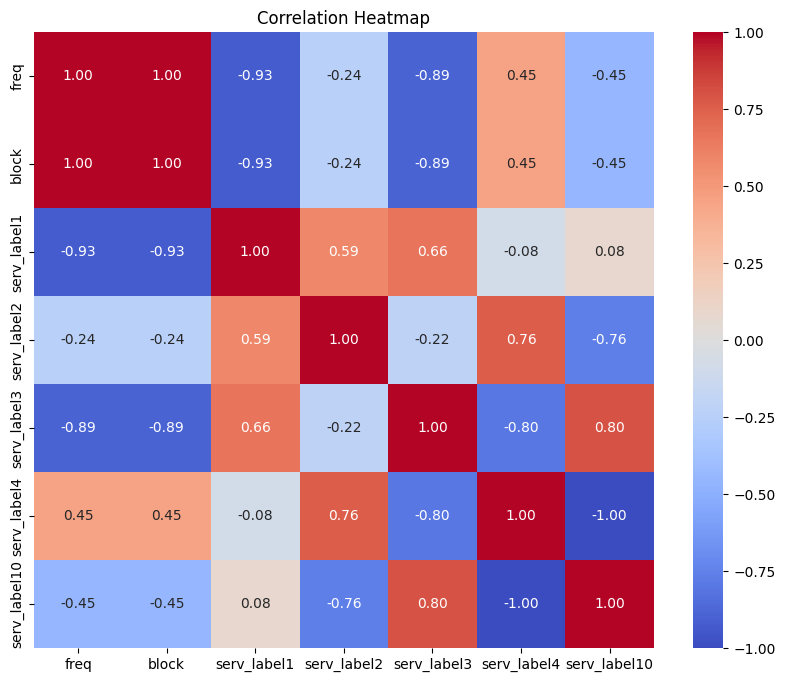

Connected to the postgreSQL DB successfully
Connected to the postgreSQL DB successfully
Connected to the postgreSQL DB successfully
Connected to the postgreSQL DB successfully
Connected to the postgreSQL DB successfully
Connected to the postgreSQL DB successfully
Connected to the postgreSQL DB successfully


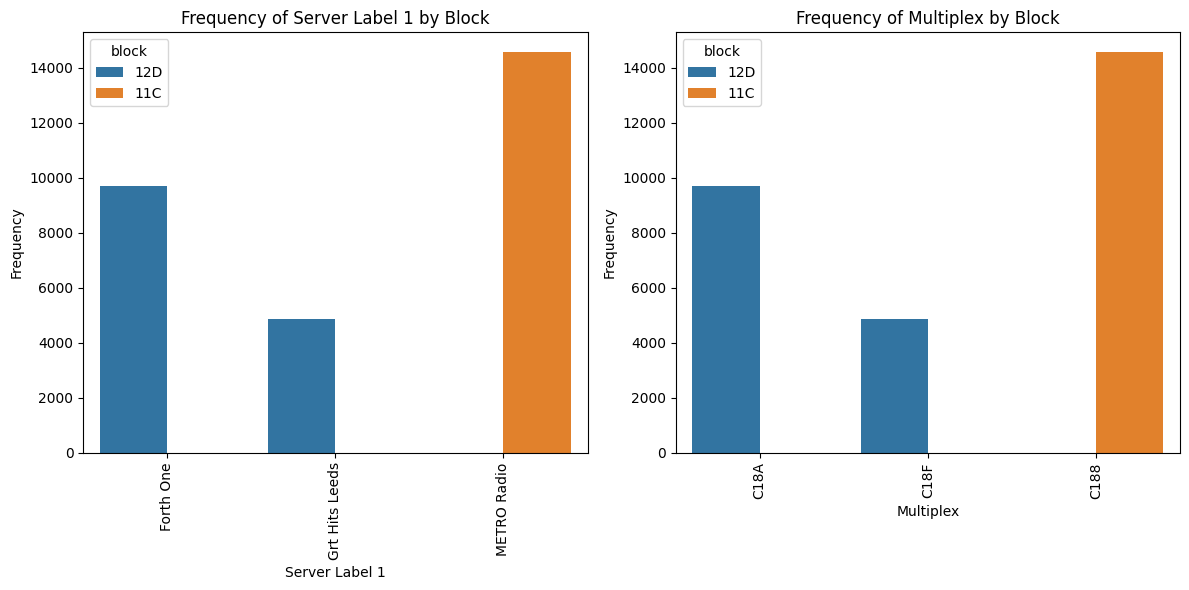

In [13]:
if __name__ == "__main__":
  main()